In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import cufflinks as cf
import plotly.express as px
import matplotlib.pylab as plt
from pandas.api.types import CategoricalDtype
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
sns.set_style("whitegrid")
# from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score,train_test_split
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv").drop("id",axis=1)

In [3]:
df.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
df.describe() 

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## analysis the effect of categorical data of the target variable

In [7]:
for i in df.select_dtypes("object"):
    for j in df[i].unique():
        p=(df[df[i]==j].stroke.mean())*100
        print(f"if [{i}]== [{j}] , the probability of have stroke is [{round(p,2)}] %")
    print("-"*60)

if [gender]== [Male] , the probability of have stroke is [5.11] %
if [gender]== [Female] , the probability of have stroke is [4.71] %
if [gender]== [Other] , the probability of have stroke is [0.0] %
------------------------------------------------------------
if [ever_married]== [Yes] , the probability of have stroke is [6.56] %
if [ever_married]== [No] , the probability of have stroke is [1.65] %
------------------------------------------------------------
if [work_type]== [Private] , the probability of have stroke is [5.09] %
if [work_type]== [Self-employed] , the probability of have stroke is [7.94] %
if [work_type]== [Govt_job] , the probability of have stroke is [5.02] %
if [work_type]== [children] , the probability of have stroke is [0.29] %
if [work_type]== [Never_worked] , the probability of have stroke is [0.0] %
------------------------------------------------------------
if [Residence_type]== [Urban] , the probability of have stroke is [5.2] %
if [Residence_type]== [Rural] 

## show the variance in stroke by the variables

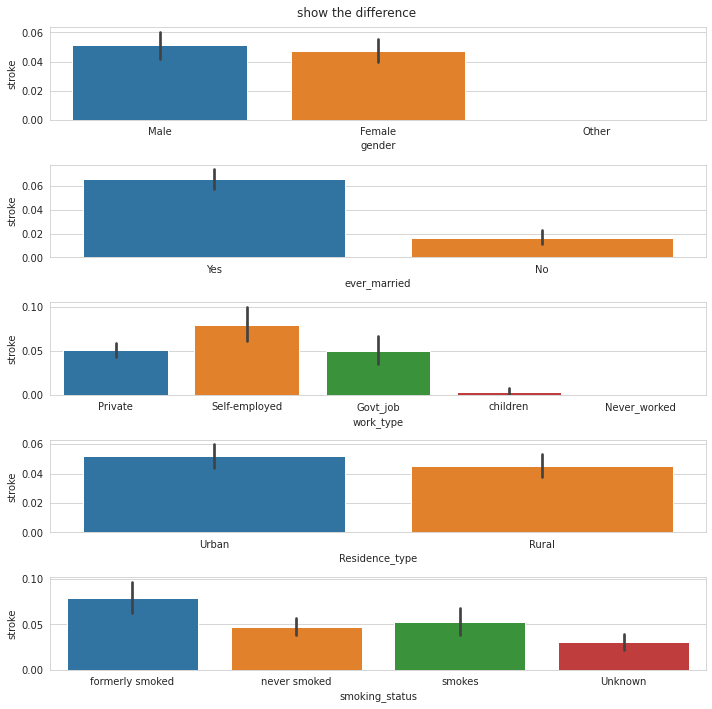

In [8]:
f,axes=plt.subplots(nrows=5,ncols=1,figsize=(10,10))
f.suptitle("show the difference")
for i,value in enumerate(df.select_dtypes("object")):
    sns.barplot(x=value,y="stroke",data=df,ax=axes[i])
plt.tight_layout()

In [9]:
# show the target varialbe
px.pie(data_frame=df["stroke"].value_counts(dropna=False),
       names=df["stroke"].value_counts(dropna=False).index,
       values=df["stroke"].value_counts(dropna=False).values,
       title="Stroke values",
      )


- there is large impalance here

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

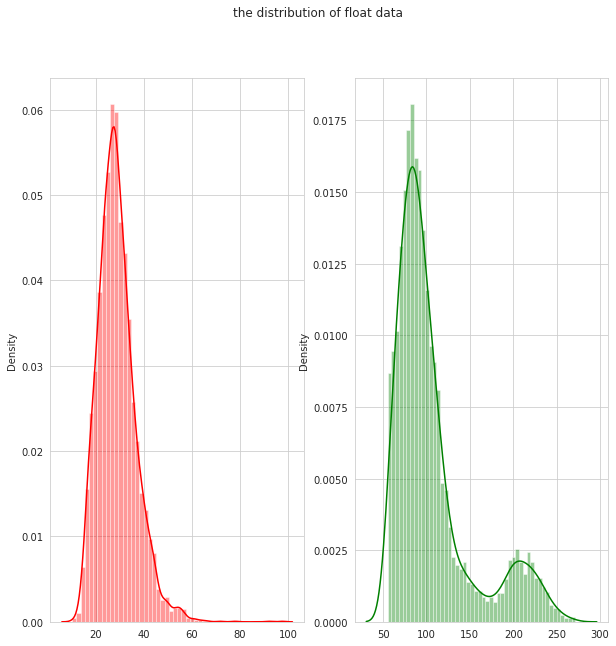

In [10]:
f,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
f.suptitle("the distribution of float data ")
sns.distplot(x=df["bmi"],color="red",ax=axes[0])
sns.distplot(x=df["avg_glucose_level"],color="green",ax=axes[1])

### start working with data_ for machine learning model

In [11]:
def load_data(df_train,df_test):
    x=pd.concat([df_train,df_test],axis=0)
    x=clean(x)
    x=encode(x)
    train=x.loc[df_train.index,:] 
    test=x.loc[df_test.index,:]
    return train,test

In [12]:
# searching for unusul value or replace them to be simple
def clean(df):
    df["smoking_status"]=df["smoking_status"].replace({
         "formerly smoked":"before",
        "never smoked":"never"
    })
    df["work_type"]=df["work_type"].replace({
        "children":"child",
        "Govt_jov":"gov",
        "Never_worked":"never",
        "Self-employed":"self",
        "Private":"private"
    })
    return df 

In [13]:
# correctly encode the object variables to categories
def encode(df):
    df["smoking_status"]=df["smoking_status"].astype(CategoricalDtype(["Unknown","never","before","smokes"],ordered=True))
    for col in df.select_dtypes(["object"]):
        df[col]=df[col].astype("category")
        if "other" not in df[col].cat.categories:
            df[col].cat.add_categories("other")
    return df 

In [14]:
def normalize(df):
    df["bmi"]=np.log1p(df["bmi"])
    df["avg_glucose_level"]=np.log1p(df["avg_glucose_level"])
    return df 

In [15]:
x=df.drop("stroke",axis=1)
y=df["stroke"]


In [16]:
df_train,df_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=0,stratify=y) 
train,test=load_data(df_train,df_test) 

In [17]:
def mi(X,y):
    for i in X.select_dtypes(["category"]):
        X[i],_=X[i].factorize()
    discreate_features=[pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    if "bmi" in X.columns:
        X["bmi"].fillna(0,inplace=True)
    scores=mutual_info_classif(X,y,discrete_features=discreate_features,random_state=0)
    series=pd.Series(scores,index=X.columns).sort_values(ascending=False)
    return series

In [18]:
mi(train,y_train) 

age                  0.040473
bmi                  0.013177
work_type            0.007843
ever_married         0.007123
hypertension         0.006949
heart_disease        0.006195
avg_glucose_level    0.004974
smoking_status       0.003040
gender               0.000023
Residence_type       0.000020
dtype: float64

In [19]:
def score_data(X,y):
    for i in X.select_dtypes(["category"]):
        X[i]=X[i].cat.codes
    scores=cross_val_score(XGBClassifier(use_label_encoder=False,eval_metric="error"),X,y,cv=StratifiedKFold(n_splits=3),scoring="roc_auc")
    print( scores.mean() )

In [20]:
score_data(train,y_train)

0.8028704473227739


- the intial score is .8

- it seams that [gender ,Residence_type ] hav very low affect on the the target 
- let's try to remove them

In [21]:
def drop_low_mi(df):
    df=df.drop(["gender","Residence_type"],axis=1)
    return df

In [22]:
# v1 -> first version 
v1=train.copy()
v1=drop_low_mi(v1)
score_data(v1,y_train)

0.8031310619727242


- it inceares the score, but very little.

### create features

In [23]:
px.scatter(train ,x="bmi",y="avg_glucose_level")

In [24]:
px.scatter(train ,x="age",y="avg_glucose_level")

In [25]:
px.scatter(train,x="age",y="bmi")

- let's try making new feature that cluster the age and the bmi

In [26]:
# know the best cluster 
ks=[1,2,3,4,5,6,7,8]
inertia=[]
for k in ks:
    kmeans=KMeans(n_clusters=k)
    x=train[["age","bmi","avg_glucose_level"]] 
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)
fig=px.line(x=ks,y=inertia,labels={"x":"number of clusters","y":"the interia"},title="numbers of clusters VS interia")
fig.add_vline(x=3)

- so , i will stick with the 3 clusters as the [ elbow point ]

In [27]:
def cluster(df):
    kmeans=KMeans(n_clusters=3, n_init=30)
    x=df[["age","bmi","avg_glucose_level"]]
    kmeans.fit(x)
    labels=kmeans.predict(x)
    X=pd.DataFrame()
    X["cluster"]=labels
    return X

In [28]:
# version 2
v2=train.copy()
v2=drop_low_mi(v2)
v2=v2.join(cluster(v2))
score_data(v2,y_train)

0.8428934547362249


- the cluster was successful

### try to get the varience between featrues with PCA.

In [29]:
def pca(df):
    data=df[["age","bmi","avg_glucose_level"]]
    pca=PCA()
    x=pca.fit_transform(data)
    
    cols=[f"pca_{i}" for i in range(len(data.columns))]
    X=pd.DataFrame(x,columns=cols)
    coefs=pd.DataFrame(pca.components_.T,index=["age","bmi","avg_glucose_level"],columns=X.columns)
    return X, coefs
    

In [30]:
X_pca,com=pca(train)
com 

,pca_0,pca_1,pca_2
age,0.152998,-0.982991,-0.101592
bmi,0.021997,-0.099389,0.994805
avg_glucose_level,0.987982,0.154438,-0.006417


In [31]:
pca_information=mi(X_pca,y_train)
pca_information

pca_1    0.021615
pca_0    0.010542
pca_2    0.007502
dtype: float64

In [32]:
def new_feature(df):
    X=pd.DataFrame()
    X["age/bmi"]=df["age"]/df["bmi"]
    return X 

In [33]:
v3=train.copy()
v3=drop_low_mi(v3)
v3=v3.join(cluster(v3))
v3=v3.join(new_feature(v3))
score_data(v2,y_train)

0.8428934547362249


## it doesn't help at all.

In [34]:
clustering=test[["age","bmi","avg_glucose_level"]]
clustering

,age,bmi,avg_glucose_level
2909,23.00,22.3,86.11
2830,49.00,29.7,125.30
107,54.00,40.4,191.82
3566,33.00,38.2,55.72
4450,59.00,25.6,81.51
...,...,...,...
3716,69.00,31.4,59.31
4256,5.00,21.7,64.45
4217,64.00,28.5,85.66
4910,0.32,19.6,108.63


In [35]:
# make a function to get the final data
def get_data(train,test):
    X=train.copy()
    X=drop_low_mi(X)
    X=X.join(cluster(X))
    X["bmi"]=X["bmi"].fillna(0)
    df_test=test.copy()
    df_test["bmi"]=df_test["bmi"].fillna(0)
    df_test=drop_low_mi(df_test)
    clustering=df_test[["age","bmi","avg_glucose_level"]]
    label=kmeans.predict(clustering)
    v=pd.DataFrame()
    v["cluster"]=label
    df_test=df_test.join(v)
    for i in X.select_dtypes(["category"]):
        X[i]=X[i].cat.codes
    for i in df_test.select_dtypes(["category"]):
        df_test[i]=df_test[i].cat.codes
    return X,df_test

In [36]:
X,X_test=get_data(train,test )

In [37]:
X.shape,X_test.shape

((4088, 9), (1022, 9))

- X : represents the valid date
- X_test : represents the unseen data [ used to make prediction after fiting the model ]

#### due to the imbalance , the model performance will be so bad in predicting [ stroke=1 ].so , let's try 
- oversampling the minority class.
- under sampling the majority class.
- try to combine both [ under_dampling , over_sampling ]

In [38]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

### what i will do :-
- apply [ over sampling and under sampling ] to the data.
- fit the data to the model and predict the x_test
- make the [ classification_report ] and see the effect in predicting the [ stroke=1]
     - i guess the important calss here is [ stroke=1 ] 
           - predicting the person to have stroke,then go to the hospital to see if it is right. is     better than predicting that he/she has no stroke to try to trea him/here in wrong ways.

In [39]:
def original_data(train,y_train,test,y_test):
    model= XGBClassifier()
    model.fit(train,y_train)
    y_pred=model.predict(test)
    print(classification_report(y_pred,y_test))

In [40]:
original_data(X,y_train,X_test,y_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[09:37:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1021
           1       0.00      0.00      0.00         1

    accuracy                           0.95      1022
   macro avg       0.50      0.48      0.49      1022
weighted avg       1.00      0.95      0.97      1022



In [41]:
def over_sampling(train,y_train,test,y_test):
    d_train,target=train.copy(),y_train.copy()
    sampling= RandomOverSampler(sampling_strategy=.4,random_state=0)
    over_x,over_y=sampling.fit_resample(d_train,target)
    model= XGBClassifier()
    model.fit(over_x,over_y)
    y_pred=model.predict(test)
    print(classification_report(y_pred,y_test))
    

In [42]:
over_sampling(X,y_train,X_test,y_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[09:37:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1016
           1       0.10      0.83      0.18         6

    accuracy                           0.95      1022
   macro avg       0.55      0.89      0.58      1022
weighted avg       0.99      0.95      0.97      1022



In [43]:
def under_sampling(train,y_train,test,y_test):
    d_train,target=train.copy(),y_train.copy()
    sampling= RandomUnderSampler(sampling_strategy=.4,random_state=0)
    over_x,over_y=sampling.fit_resample(d_train,target)
    model= XGBClassifier()
    model.fit(over_x,over_y)
    y_pred=model.predict(test)
    print(classification_report(y_pred,y_test))

In [44]:
under_sampling(X,y_train,X_test,y_test)

[09:37:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       976
           1       0.50      0.54      0.52        46

    accuracy                           0.95      1022
   macro avg       0.74      0.76      0.75      1022
weighted avg       0.96      0.95      0.96      1022



/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



- it seems that under_sampling did a good work rather than over_sampling
- let's combine them

In [45]:
def over_under_sampling(train,y_train,test,y_test):
    d_train,target=train.copy(),y_train.copy()
    sampling= RandomOverSampler(sampling_strategy=.3,random_state=0)
    over_x,over_y=sampling.fit_resample(d_train,target)
    sampling= RandomUnderSampler(sampling_strategy=.4,random_state=0)
    over_under_x,over_under_y=sampling.fit_resample(over_x,over_y)
    model= XGBClassifier()
    model.fit(over_under_x,over_under_y)
    y_pred=model.predict(test)
    print(classification_report(y_pred,y_test))

In [46]:
over_under_sampling(X,y_train,X_test,y_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[09:37:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1012
           1       0.10      0.50      0.17        10

    accuracy                           0.95      1022
   macro avg       0.55      0.73      0.57      1022
weighted avg       0.99      0.95      0.97      1022



#### as it looks like , under_sampling is the best here   ......... [ for me ]

## if i did somthing wrong or you have any other ideas. please, tel me.
#### thanks